# 예측 애널리틱스: KNN 실습

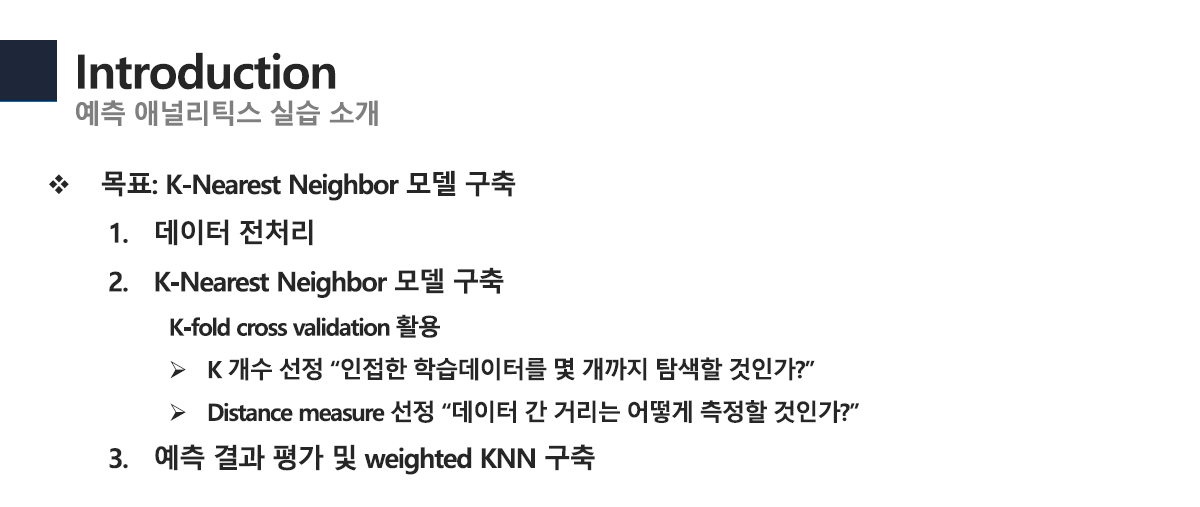

이지윤 / jiyoonlee@korea.ac.kr

## 1. 모듈 불러오기

In [ ]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action='ignore')

# 실습용 데이터 패키지
from sklearn.datasets import load_breast_cancer

# 데이터 전처리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy.stats import spearmanr

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## 2. 데이터 불러오기: Breast Cancer

#### 데이터 구조
- 데이터: 위스콘신 대학교에서 제공한 유방암 진단결과
- 관측치 개수: 569개
- 변수 개수: 32개 (ID, 진단결과, 30개의 실측변수 값)

#### 설명 변수(원인: 예측값을 설명할 수 있는 변수)      
- id: 환자 식별 번호
- radius: 반경 (중심에서 외벽까지 거리들의 평균값)
- texture: 질감(Gray-Scale값들의 표준편차)
- perimeter: 둘레
- area: 면적
- smoothness: 매끄러움(반경길이의 국소적 변화)
- compactness: 조그만 정도(둘레^2/면적-1)
- concavity: 오목함(윤곽의 오목한 부분의 정도)
- points: 오목한 점의 수
- symmetry: 대칭
- dimension: 프랙탈 차원(해안선 근사-1)
- mean: 3~12번 까지는 평균값을 의미
- se: 13~22번까지는 표준오차를 의미
- worst: 23~32는 각 세포별 구분들에서 제일 큰 3개의 값을 평균낸 값

#### 반응 변수(결과: 예측하고자 하는 값)
- diagnosis: 양성여부(Maligant=1 악성(유방암), Benign=0 양성(단순낭종))

In [ ]:
# 데이터셋 로드 및 설명 
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

In [ ]:
breast_cancer.data.shape

## 3. 탐색적 데이터 분석 및 데이터 전처리

$\mathbf{X}$: 독립변수, 예측변수, 입력변수 <br>
$\mathbf{y}$: 종속변수, 반응변수, 출력변수

In [ ]:
# 데이터 프레임 형태로 변환
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns=['diagnosis'])

In [ ]:
X.head()

In [ ]:
y.tail()

### 결측치, 데이터 타입 확인

In [ ]:
X.info()

In [ ]:
X.describe()

In [ ]:
y['diagnosis'].value_counts()

### Train/Test 데이터 분리
- Training 데이터 70% / Testing 데이터 30% 나누기

In [ ]:
# Train set/ Test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,random_state=2021)

# 데이터 컬럼 단위 정규화 하기
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

## 4. 모델링
- K 개수 결정
- Distance measure 결정

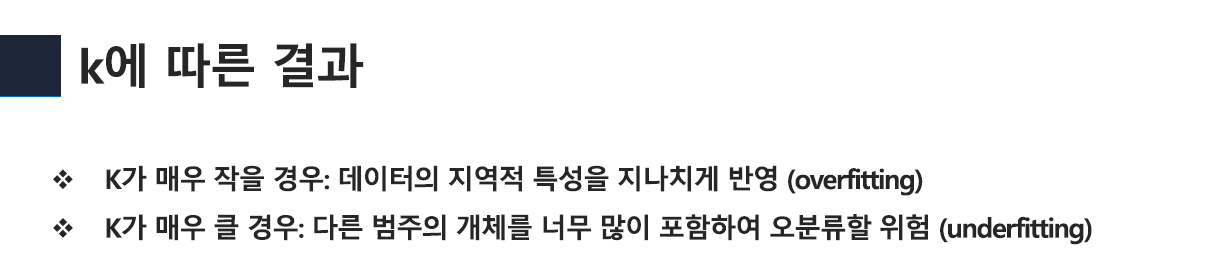

In [ ]:
X_vis = X_train[:, :2]  # we only take the first two features. We could
                        # avoid this ugly slicing by using a two-dim dataset
y_vis = y_train.values.ravel()

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for k in [1, 50]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_vis, y_vis)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"2-Class classification (k = {k}')", fontsize=10)

plt.show()

### 4.1 Hyperparameter k 결정

In [ ]:
k_list = [i for i in range(1,100) if i%2 !=0]
cv_scores = []

for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=2)  # p=1: manhattan_distance , p=2: euclidean_distance
                                                             # p=l_p: minkowski_distance
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

In [ ]:
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print("Best k value : ", best_k)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.legend(["Cross validation scores"], fontsize=20)
plt.xlabel("k value", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()

### 4.2 Distance type 결정

#### 4.2.1. Euclidean Distance
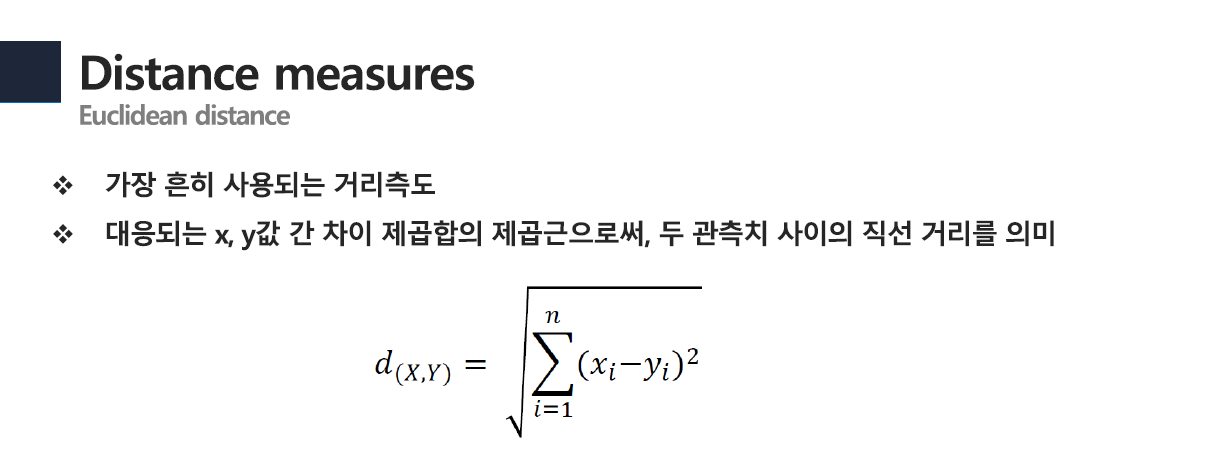

In [ ]:
k_list = [i for i in range(1,100) if i%2 !=0]

euc = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=2)  
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    euc.append(scores.mean()) 

#### 4.2.2. Manhattan Distance
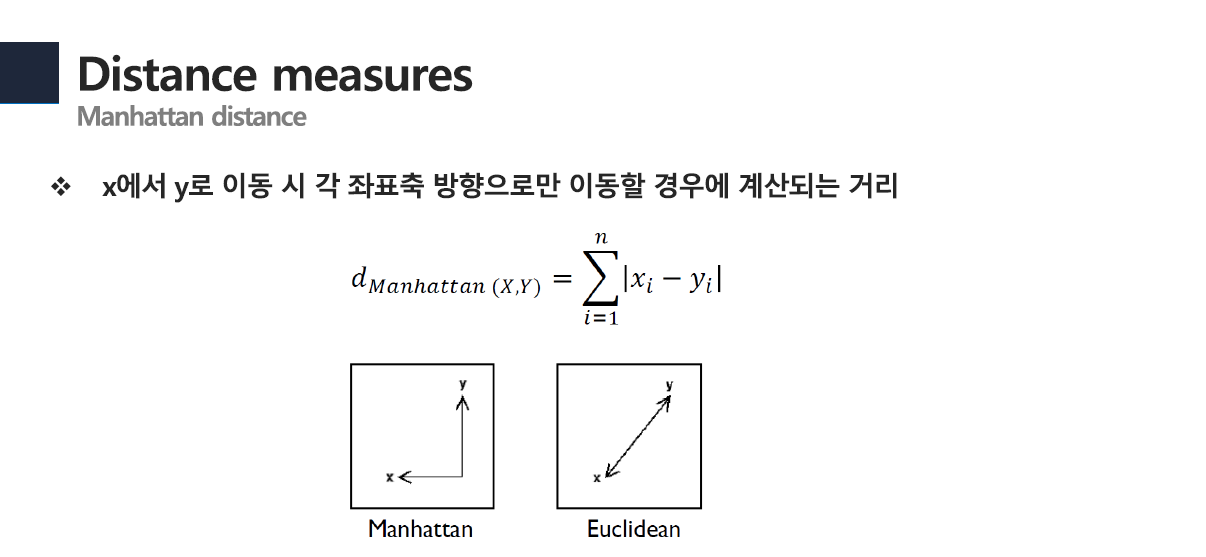

In [ ]:
k_list = [i for i in range(1,100) if i%2 !=0]

man = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=1) 
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    man.append(scores.mean()) 

#### 4.2.3. Mahalanobis Distance
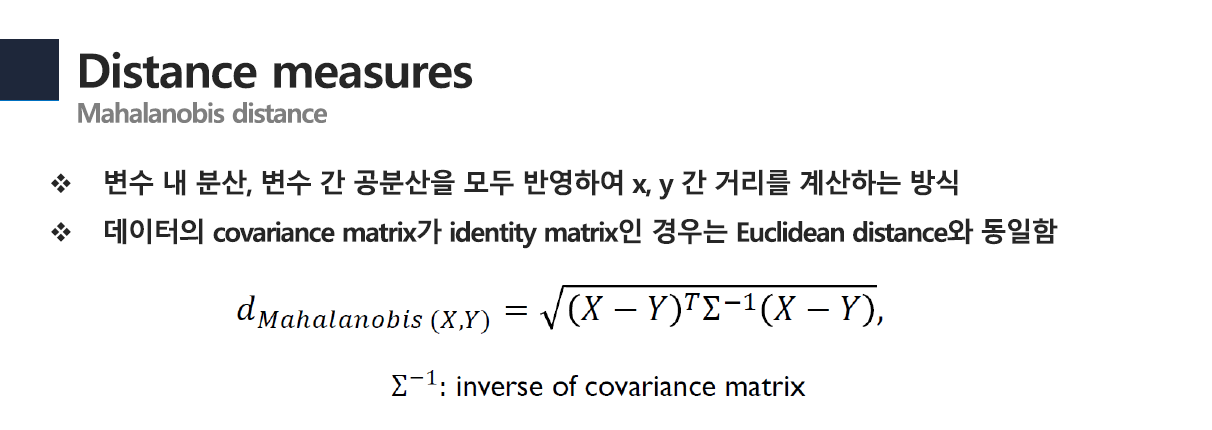

In [ ]:
y_train = y_train.values.ravel()
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

mah = []
for k in tqdm(k_list):

# K-fold cross validation
    mah_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]

        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]


        total = len(y_valid_f)
        correct = 0

        nn = NearestNeighbors(algorithm='brute', metric='mahalanobis', 
                              metric_params={'V':np.cov(X_train_f, rowvar=False)}, n_neighbors=k)
        nn_model = nn.fit(X_train_f,y_train_f)


        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] +=  1
                else :
                    class_list['1'] += 1

            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1

        mah_acc.append(correct/total)
        
    mah.append(np.mean(mah_acc))

#### 4.2.4. Correlation Distance - Pearson Correlation
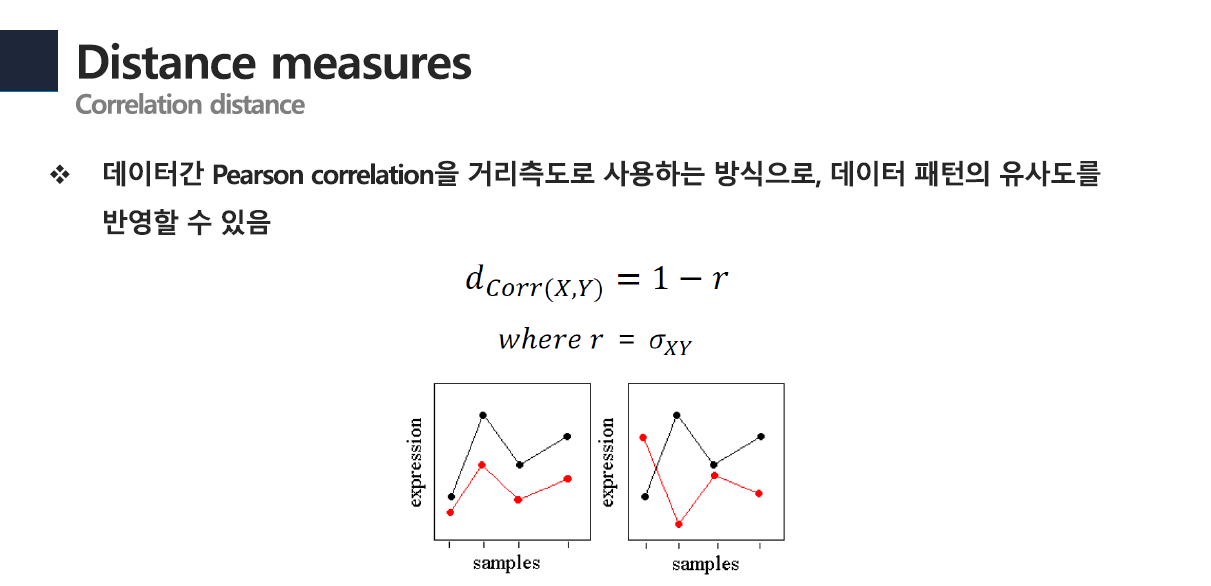

In [ ]:
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

pear = []
for k in tqdm(k_list):

# K-fold cross validation
    pear_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]

        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]


        total = len(y_valid_f)
        correct = 0

        nn = NearestNeighbors(metric='correlation', n_neighbors=k)
        nn_model = nn.fit(X_train_f,y_train_f)


        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] += 1
                else :
                    class_list['1'] += 1

            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1

        pear_acc.append(correct/total)
        
    pear.append(np.mean(pear_acc))

#### 4.2.5. Correlation Distance - Spearman Rank Correlation
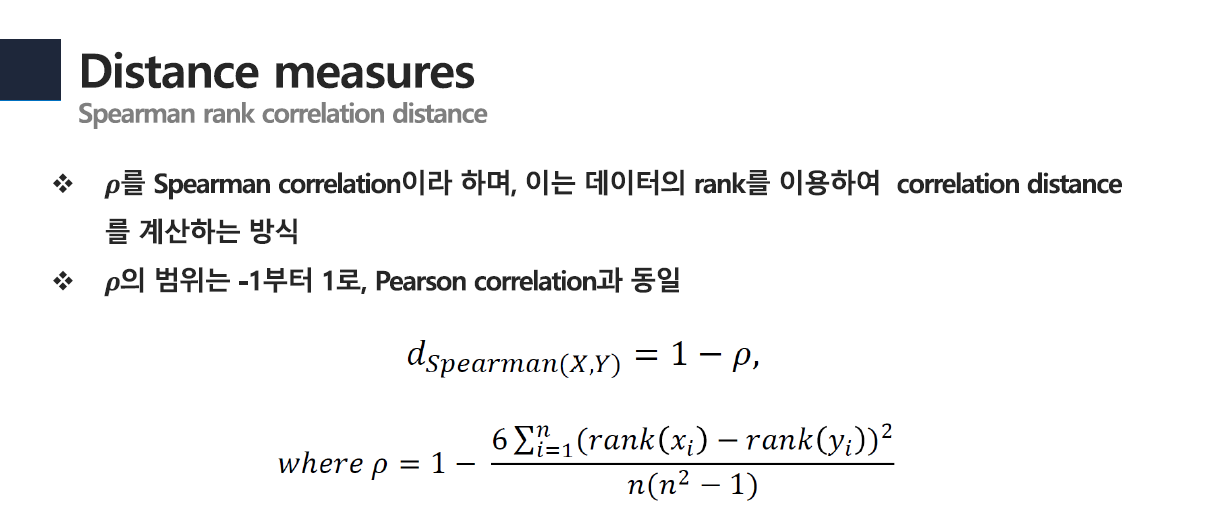

In [ ]:
def spearmancorr(x,y):
    rho, pval = spearmanr(x, y, axis=0)
    return 1-rho

kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

spear = []
for k in tqdm(k_list):

# K-fold cross validation
    spear_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]

        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]


        total = len(y_valid_f)
        correct = 0

        nn = NearestNeighbors(metric = spearmancorr, n_neighbors=k, algorithm='ball_tree')
        nn_model = nn.fit(X_train_f,y_train_f)

        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] += 1
                else :
                    class_list['1'] += 1

            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1

        spear_acc.append(correct/total)
    spear.append(np.mean(spear_acc))

In [ ]:
plt.figure(figsize=(15,10))
# plt.plot(k_list, acc_spear, marker='o', linestyle='dashed')
plt.plot(k_list, euc, marker='o')
plt.plot(k_list, man, linestyle='dashed', marker='p')
plt.plot(k_list, mah, marker='s')
plt.plot(k_list, pear, marker='d')
plt.plot(k_list, spear, marker='v')
plt.axvline(5, color='r', linestyle='--', linewidth=2)
plt.xlabel("k value")
plt.ylabel("Cross validation scores")
plt.title("Comparison by distance measures")
plt.legend(["Euclidean","Manhattan","Mahalanobis","Pearson Corr","Spearman Rank Corr"])
plt.show()

### 4.2 최종 모델 선정 및 성능 확인

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 5, p=2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_true = y_test, y_pred =y_pred) ## 정확도
recall = recall_score(y_true = y_test, y_pred =y_pred) ## 민감도
precision = precision_score(y_true = y_test, y_pred =y_pred) ## 정밀도

print(f"정확도:{acc:0.2f}",f"민감도:{recall:0.2f}",f"정밀도:{precision:0.2f}", sep='  |  ')  

### 4.3 Weighted KNN 적용 및 성능확인

In [ ]:
k_list = [i for i in range(1,100) if i%2 !=0]

euc = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=2, weights='distance') # weights{‘uniform’, distance’} or callable, 
                                                                                # default=’uniform’
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    euc.append(scores.mean()) 
    
best_k = [k_list[i] for i in range(len(euc)) if euc[i] == np.max(euc)]
print("Best k value : ", best_k)

plt.figure(figsize=(20,10))
plt.plot(k_list, euc, marker='o', linestyle='dashed')
plt.legend(["Cross validation scores"], fontsize=20)
plt.xlabel("k value", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 5, p=2, weights='distance')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_true = y_test, y_pred =y_pred) ## 정확도
recall = recall_score(y_true = y_test, y_pred =y_pred) ## 민감도
precision = precision_score(y_true = y_test, y_pred =y_pred) ## 정밀도


print(f"정확도:{acc:0.2f}",f"민감도:{recall:0.2f}",f"정밀도:{precision:0.2f}", sep='  |  ')  

### Regression 예시

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston
boston = load_boston()

# 데이터 프레임 형태로 변환
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

k_list = [i for i in range(1,100) if i%2 !=0]
cv_scores = []
for k in tqdm(k_list):
    regressor = KNeighborsRegressor(n_neighbors = k, p=2)  # p=1: manhattan_distance , p=2: euclidean_distance
                                                             # p=l_p: minkowski_distance
    scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring = 'r2')
    cv_scores.append(scores.mean())
    
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print("Best k value : ", best_k)

plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.legend(["Cross validation scores"], fontsize=20)
plt.xlabel("k value", fontsize=20 )
plt.ylabel("r2", fontsize=20)
plt.title("r2 Score", fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()

https://scikit-learn.org/stable/modules/model_evaluation.html

### EOD